
##  Exploring the Relationship Between Optimal "K"-Nearest Neighbors and Sample Density for Geospatial Prediction of Land Surface Temperature

#### Xihan Yao
#### Department of Geography and the Environment, College of Liberal Arts

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Maria Gonzalez, Graduate Student, The University of Texas at Austin


### Executive Summary

To be completed.
* What is the gap, problem, opportunity, scientific question?

* What was done to address the above?

* What was learned?

* What are your recommendations?

**Guidance**: Write as a single paragraph with 4 or so well-writen sentences.

### Import Packages


In [86]:
%matplotlib inline                                         
suppress_warnings = True
from datetime import datetime
import os                                                     # to set current working directory 
import math                                                   # square root operator
import numpy as np                                            # arrays and matrix math
import scipy.stats as st                                      # statistical methods
import pandas as pd                                           # DataFrames
import pandas.plotting as pd_plot
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator,AutoMinorLocator,FuncFormatter) # control of axes ticks
from matplotlib.colors import ListedColormap                  # custom color maps
import seaborn as sns                                         # for matrix scatter plots
from sklearn import metrics                                   # measures to check our models
from sklearn.preprocessing import StandardScaler              # standardize the features
from sklearn.neighbors import KNeighborsRegressor             # for nearest k neighbours
from sklearn import metrics                                   # measures to check our models
from sklearn.model_selection import (cross_val_score,train_test_split,GridSearchCV,KFold) # model tuning
from sklearn.pipeline import (Pipeline,make_pipeline)         # machine learning modeling pipeline
from IPython.display import display, HTML                     # custom displays
cmap = plt.cm.inferno                                         # default color bar, no bias and friendly for color vision defeciency
plt.rc('axes', axisbelow=True)                                # grid behind plotting elements
if suppress_warnings == True:  
    import warnings                                           # suppress any warnings for this demonstration
    warnings.filterwarnings('ignore') 
seed = 13                                                     # random number seed for workflow repeatability

### Functions

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), MachineLearning_knearest_neighbours.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/MachineLearningDemos_Book/blob/main/MachineLearning_knearest_neighbours.html). 

In [2]:
def comma_format(x, pos):
    return f'{int(x):,}'

def feature_rank_plot(pred,metric,mmin,mmax,nominal,title,ylabel,mask): # feature ranking plot
    mpred = len(pred); mask_low = nominal-mask*(nominal-mmin); mask_high = nominal+mask*(mmax-nominal); m = len(pred) + 1
    plt.plot(pred,metric,color='black',zorder=20)
    plt.scatter(pred,metric,marker='o',s=10,color='black',zorder=100)
    plt.plot([-0.5,m-1.5],[0.0,0.0],'r--',linewidth = 1.0,zorder=1)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric < nominal),interpolate=True,color='dodgerblue',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric > nominal),interpolate=True,color='lightcoral',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_low),metric,where=(metric < mask_low),interpolate=True,color='blue',alpha=0.8,zorder=10)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_high),metric,where=(metric > mask_high),interpolate=True,color='red',alpha=0.8,zorder=10)  
    plt.xlabel('Predictor Features'); plt.ylabel(ylabel); plt.title(title)
    plt.ylim(mmin,mmax); plt.xlim([-0.5,m-1.5]); add_grid();
    return

def plot_corr(corr_matrix,title,limits,mask):                 # plots a graphical correlation matrix 
    my_colormap = plt.get_cmap('RdBu_r', 256)          
    newcolors = my_colormap(np.linspace(0, 1, 256))
    white = np.array([256/256, 256/256, 256/256, 1])
    white_low = int(128 - mask*128); white_high = int(128+mask*128)
    newcolors[white_low:white_high, :] = white                # mask all correlations less than abs(0.8)
    newcmp = ListedColormap(newcolors)
    m = corr_matrix.shape[0]
    im = plt.matshow(corr_matrix,fignum=0,vmin = -1.0*limits, vmax = limits,cmap = newcmp)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns); ax = plt.gca()
    ax.xaxis.set_label_position('bottom'); ax.xaxis.tick_bottom()
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
    plt.title(title)
    for i in range(0,m):
        plt.plot([i-0.5,i-0.5],[-0.5,m-0.5],color='black')
        plt.plot([-0.5,m-0.5],[i-0.5,i-0.5],color='black')
    plt.ylim([-0.5,m-0.5]); plt.xlim([-0.5,m-0.5])
    
def visualize_model(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,title,axes_commas = True): # plots the data points and the decision tree prediction 
    n_classes = 10
    cmap_temp = plt.cm.inferno
    xplot_step = (x_max-x_min)/100; yplot_step = (y_max-y_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step),
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap_temp,vmin=z_min, vmax=z_max, levels=np.linspace(z_min, z_max, 100))

    im = plt.scatter(xfeature,yfeature,s=30, c=response, marker=None, cmap=cmap_temp, norm=None, vmin=z_min, vmax=z_max, 
                     alpha=1.0, linewidths=0.8, edgecolors="black",zorder=10)
    plt.scatter(xfeature,yfeature,s=60, c='white', marker=None, cmap=cmap_temp, norm=None, vmin=z_min, vmax=z_max, 
                     alpha=1.0, linewidths=0.8, edgecolors=None,zorder=8)
    plt.title(title); plt.xlabel(xfeature.name); plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical'); cbar.set_label(response.name, rotation=270, labelpad=20)
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
    if axes_commas == True:
        plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
        plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))
    return Z
    
def visualize_tuned_model(k_tuned,k_mat,score_mat):
    plt.scatter(k_mat,score_mat,s=10.0, c="red", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, 
                linewidths=0.5, edgecolors="black")
    plt.plot([k_tuned,k_tuned],[0,10000000],color='black',linestyle=(6, (2,3)),label='tuned',zorder=1)
    plt.title('k-fold Cross Validation Error (MSE) vs. k Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours')
    plt.ylabel('Mean Square Error')
    plt.xlim(k_min,k_max); plt.ylim(0,np.max(score_mat))
    
def check_model(model,xtrain,ytrain,xtest,ytest,ymin,ymax,rtrain,rtest,title): # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xtrain,ytrain])
    predict_test = model.predict(np.c_[xtest,ytest])
    plt.scatter(rtrain,predict_train,s=None, c='darkorange',marker=None, cmap=None, norm=None, vmin=None, vmax=None, 
                alpha=0.8, linewidths=0.8, edgecolors="black",label='Train')
    plt.scatter(rtest,predict_test,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, 
                alpha=0.8, linewidths=0.8, edgecolors="black",label='Test')
    plt.title(title); plt.xlabel('Actual Production (MCFPD)'); plt.ylabel('Estimated Production (MCFPD)')
    plt.xlim(ymin,ymax); plt.ylim(ymin,ymax)
    plt.arrow(ymin,ymin,ymax,ymax,width=0.02,color='black',head_length=0.0,head_width=0.0)
    MSE_train = metrics.mean_squared_error(rtrain,predict_train)
    Var_Explained_train = metrics.explained_variance_score(rtrain,predict_train)
    cor_train = math.sqrt(metrics.r2_score(rtrain,predict_train))
    MSE_test = metrics.mean_squared_error(rtest,predict_test)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))
    plt.annotate('Train MSE: ' + str(f'{(np.round(MSE_train,2)):,}'),[0.05*(ymax-ymin)+ymin,0.95*(ymax-ymin)+ymin]) 
    plt.annotate('Test MSE:  ' + str(f'{(np.round(MSE_test,2)):,}'),[0.05*(ymax-ymin)+ymin,0.90*(ymax-ymin)+ymin])
    add_grid(); plt.legend(loc='lower right')
    # print('Mean Squared Error on Training = ', round(MSE_test,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

def weighted_percentile(data, weights, perc):                 # calculate weighted percentile (iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049) 
    ix = np.argsort(data)
    data = data[ix] 
    weights = weights[ix] 
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) 
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color):                   # add uncertainty bounds to a histogram          
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')

def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks 

def display_sidebyside(*args):                                # display DataFrames side-by-side (ChatGPT 4.0 generated Spet, 2024)
    html_str = ''
    for df in args:
        html_str += df.head().to_html()  # Using .head() for the first few rows
    display(HTML(f'<div style="display: flex;">{html_str}</div>'))

## Data & Study Background 

The following workflow uses the .csv file “LST_samples_with_bands_and_indices.csv”, a synthetic dataset generated by Xihan Yao from Landsat imagery near Austin, TX. All images were acquired by the same Landsat satellite during Summer 2025. Landsat data are publicly available and can be accessed through multiple platforms. A brief explanation of how this dataset was generated is provided below.

This dataset is synthetic. I generated it using the Land Surface Temperature (LST) layer from Landsat 8 as the underlying source. A total of 3,924 samples were collected. The first 500 samples were drawn completely at random, while the remaining 1,924 were intentionally sampled near temperature “hotspots,” identified based on the highest values among the initial 2000 points.

Because of the urban heat island effect, urbanized areas are typically warmer than their surrounding rural environments. This pattern is reflected in Austin, where the city center exhibits higher surface temperatures than its peripheral regions. I assume that more people reside in these urbanized zones, leading to greater participation in citizen science activities and increased data collection from their homes. This results in higher sampling density in urban areas.

Consequently, the final sample distribution is not entirely spatially random. Additionally, no samples were taken over water bodies.

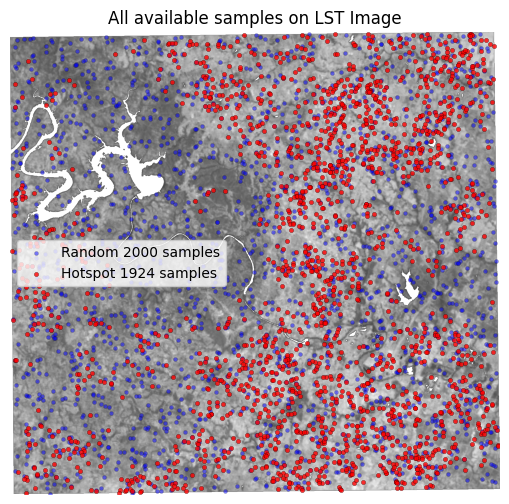

Following this sampling step, I extracted the corresponding values of Landsat Bands 2 through 9 at each sample location and calculated several vegetation indices. From this point forward, our analysis is based solely on the resulting tabular dataset. The remote sensing images are used only as the initial source for data extraction and will not be directly involved in the subsequent workflow.

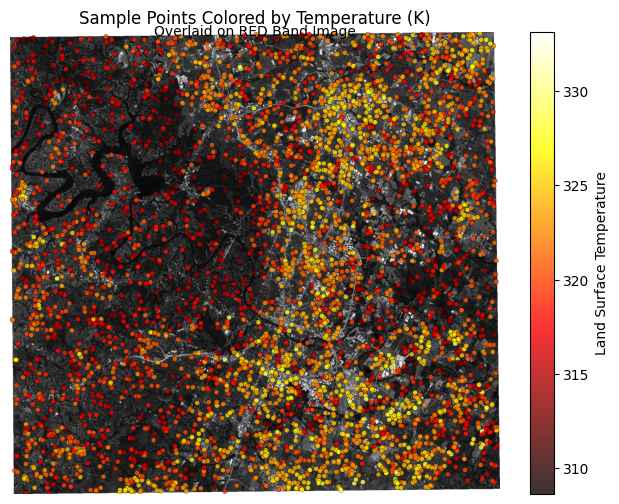


We will work with the following features:

* **Land Surface Temperature (LST, or simply Temperature)** – a measurement of the Earth’s surface temperature derived from thermal infrared radiation. Not the same as air temperature, but used here as a proxy for near-surface air temperature.

* **X_coor** – X coordinate of the sample (column position).
* **Y_coor** – Y coordinate of the sample (row position).

* **NDVI** – Normalized Difference Vegetation Index; measures vegetation greenness using NIR and Red reflectance. (B5 - B4) / (B5 + B4)

We will explore but not work on the following features:

* **B2 Blue** – reflectance of blue light in the electromagnetic spectrum.
* **B3 Green** – reflectance of green light in the electromagnetic spectrum.
* **B4 Red** – reflectance of red light, important for vegetation analysis.
* **B5 NIR** – reflectance of near-infrared energy, strongly responsive to healthy vegetation.
* **B6 SWIR1** – reflectance in the shortwave infrared region, sensitive to soil and vegetation moisture.
* **B7 SWIR2** – reflectance in the deeper shortwave infrared region, useful for detecting burned or dry surfaces.
* **B8 Panchromatic** – high-resolution grayscale band used for pan-sharpening.
* **B9 Cirrus** – reflectance used to detect high-altitude thin cirrus clouds.

* **EVI** – Enhanced Vegetation Index; improves vegetation sensitivity by reducing atmospheric and canopy background effects. 2.5 * (B5 - B4) / (B5 + 6*B4 - 7.5*B2 + 1)
* **NDWI** – Normalized Difference Water Index; highlights open water and vegetation moisture using Green and NIR reflectance. (B3 - B5) / (B3 + B5)

## Step 0: Data Preperation and Exploration

Load data \
Check the last 5 inputs of the data. X_coor and Y_coor are the relative geographic coordinates of the sample points within the study scope.
Since geographic projection system is not an important part of this study. I will drop the real x y coordinates and use the relative coordinates to represent geographic information in this study

In [29]:
url = "https://raw.githubusercontent.com/xyaoaf/PGE_383_TermProject_XihanYao/main/LST_samples_with_bands_and_indices.csv"
df = pd.read_csv(url).rename(columns={'land surface temperature':'Temperature'})
df.tail()

,x_coor,y_coor,x,y,Temperature,B2_blue,B3_green,B4_red,B5_NIR,B6_SWIR1,B7_SWIR2,B8_pan,B9_cirrus,NDVI,EVI,NDWI
3919,1161,402,625935.0,3368625.0,324.522156,0.343863,0.305664,0.294550,0.533043,0.342576,0.223788,0.160471,0.001534,0.288177,0.826530,-0.271106
3920,1151,417,625635.0,3368175.0,325.062225,0.349245,0.356557,0.381535,0.713332,0.453448,0.299522,0.125149,0.001045,0.303047,0.599687,-0.333469
3921,602,1641,609165.0,3331455.0,324.710144,0.263605,0.247576,0.251028,0.773174,0.473961,0.245471,0.094784,0.001045,0.509808,1.002350,-0.514913
3922,630,1659,610005.0,3330915.0,323.623230,0.266998,0.252666,0.250384,0.851034,0.490691,0.230690,0.093917,0.001334,0.545342,1.111608,-0.542148
3923,595,1651,608955.0,3331155.0,323.872742,0.246640,0.218562,0.189138,0.730705,0.407976,0.196255,0.098141,0.001289,0.588761,1.332955,-0.539515


data summary\
x_coor and y_coor are relative coordinates within the Area of Interests (starting from 0, each pixel is incremental 1)\
x and y are absolute coordinates to the Projected Coordinate System

In [30]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
x_coor,3924.0,1.003373e+03,484.266950,5.000000e+00,6.477500e+02,1.083000e+03,1.395000e+03,1.777000e+03
y_coor,3924.0,8.702317e+02,505.047647,5.000000e+00,4.130000e+02,8.925000e+02,1.329250e+03,1.680000e+03
x,3924.0,6.212062e+05,14528.008510,5.912550e+05,6.105375e+05,6.235950e+05,6.329550e+05,6.444150e+05
y,3924.0,3.354578e+06,15151.429411,3.330285e+06,3.340808e+06,3.353910e+06,3.368295e+06,3.380535e+06
Temperature,3924.0,3.210052e+02,3.584383,3.086420e+02,3.184817e+02,3.214340e+02,3.237224e+02,3.331321e+02
B2_blue,3924.0,2.846186e-01,0.089499,1.914191e-01,2.327620e-01,2.612648e-01,3.057812e-01,1.000000e+00
B3_green,3924.0,2.655210e-01,0.109439,1.277155e-01,2.008079e-01,2.381584e-01,2.932628e-01,1.000000e+00
B4_red,3924.0,2.552204e-01,0.140695,6.664436e-02,1.666601e-01,2.225396e-01,3.012916e-01,1.000000e+00
B5_NIR,3924.0,6.926395e-01,0.123157,8.325759e-02,6.111517e-01,6.797251e-01,7.675149e-01,1.000000e+00
B6_SWIR1,3924.0,3.731349e-01,0.128798,0.000000e+00,2.795550e-01,3.594037e-01,4.464477e-01,1.000000e+00


The response feature in this study is "land surface temperature". The predictors are x_coor and y_coor, relative coordinates of the sample locations within the Area of Interests (AOI)

In [32]:
response = 'Temperature'   # response (y)

np.random.seed(seed=seed)               # random seed

# 2. Select predictors and response
# Drop response + source coordinate columns from predictors
X = df.drop(columns=[response, 'x', 'y'])
y = df[response]

# Predictor and response labels
pred = X.columns.tolist()
resp = [response]

# Rebuild df as predictors + response
df = pd.concat([X, y], axis=1)

# 3. Feature names for plotting
featurelabel = pred + resp
featuretitle = featurelabel

resplabel = 'Land Surface Temperature (K)'

# 4. Plot ranges (auto from data)
Xmin = X.min().tolist()
Xmax = X.max().tolist()
ymin = y.min()
ymax = y.max()

m = len(pred) + 1     # number of predictors + response
mpred = len(pred)      # number of predictors

print("Predictors:", pred)
print("Response:", response)
print(df.head())

Predictors: ['x_coor', 'y_coor', 'B2_blue', 'B3_green', 'B4_red', 'B5_NIR', 'B6_SWIR1', 'B7_SWIR2', 'B8_pan', 'B9_cirrus', 'NDVI', 'EVI', 'NDWI']
Response: Temperature
   x_coor  y_coor   B2_blue  B3_green    B4_red    B5_NIR  B6_SWIR1  B7_SWIR2  \
0     603     264  0.208734  0.162112  0.113091  0.517424  0.205107  0.084564   
1     924     725  0.265945  0.214233  0.190425  0.549656  0.237788  0.134326   
2     467     775  0.218445  0.180773  0.138421  0.593588  0.190990  0.079884   
3     538    1014  0.281388  0.253192  0.241259  0.733513  0.437381  0.244457   
4     539      37  0.225347  0.200311  0.157725  0.738252  0.312352  0.136666   

     B8_pan  B9_cirrus      NDVI       EVI      NDWI  Temperature  
0  0.077290   0.001134  0.641274  1.603315 -0.522875    314.24417  
1  0.083514   0.001223  0.485395  1.287348 -0.439099    320.11633  
2  0.107544   0.001111  0.621806  1.448148 -0.533105    320.67004  
3  0.103609   0.001111  0.504995  1.149422 -0.486793    319.97960  
4  0.

Before running any models, let us do some Exploratory data analysis. First check if there are any intercorrelations. And then check the correlation of each features with land surface temperature.
It is reasonable that X_coor and Y_coor do not have any correlation with any other features. Some others, though, are highly correlated. e.g. NDVI and EVI are correlated. This is because these to indices are comparable and are both used for representing the abundance of vegetation. 

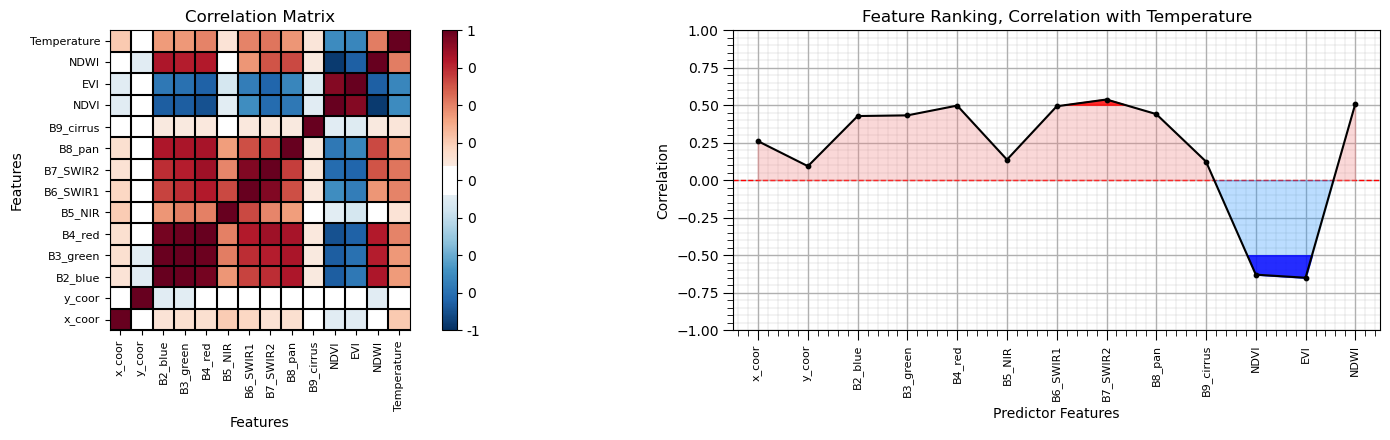

In [36]:
# Subset df to predictors + response
df_corr = df[pred + resp]

# Correlation matrix
corr_matrix = df_corr.corr()

# Correlation of predictors with response
correlation = corr_matrix[response].loc[pred].values

plt.figure(figsize=(16, 5))

# ---- Left plot: correlation matrix ----
plt.subplot(121)
plot_corr(corr_matrix, 'Correlation Matrix', 1.0, 0.1)  # mask value set to 0.1
plt.xlabel('Features')
plt.ylabel('Features')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

# ---- Right plot: correlation ranking ----
plt.subplot(122)
feature_rank_plot(pred, correlation, -1.0, 1.0, 0.0,
                  'Feature Ranking, Correlation with ' + resp[0],
                  'Correlation', 0.5)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Correlation")

# Adjust layout
plt.subplots_adjust(left=0.05, bottom=0.25, right=0.98, top=0.85,
                    wspace=0.3, hspace=0.3)

plt.show()

Sample size and sample density
My AOI is definted by a bounding box. Here I have to calculate the total area, and then determined the relationship between data density and sample sizes

In [37]:
# Estimating the AOI area: 
aoi = [-98.05, 30.10, -97.50, 30.55]  
min_lon, min_lat, max_lon, max_lat = aoi
dlat = max_lat - min_lat   # 0.45°
dlon = max_lon - min_lon   # 0.55°

lat_mid = (min_lat + max_lat) / 2
km_per_deg_lat = 111.32
km_per_deg_lon = 111.32 * math.cos(math.radians(lat_mid))

height_km = dlat * km_per_deg_lat
width_km = dlon * km_per_deg_lon

area_km2 = height_km * width_km
print(f"Estimated area_km2: {area_km2:.2f} km²")

Estimated area_km2: 2647.41 km²


I will need about 2700 samples in order to make the data density reach 1 sample per km2. One may argue that having so many measurments is near impossible. So I decide to do a testing. I assume when we take more samples, we will achieve higher model accuracy, and lower MSE.

But here is my key question, how about the K value for KNN. How will the optional K value change as we change the sample size? 

Our data set consists of 3925 Pseudo samples. They are taken from the Raster images of Land Surface Temperature of Landsat images. Which means that we can take a many as we want. But when talking about ground measuremnt, adding one more point means adding one more device and the costs add up quickly. 

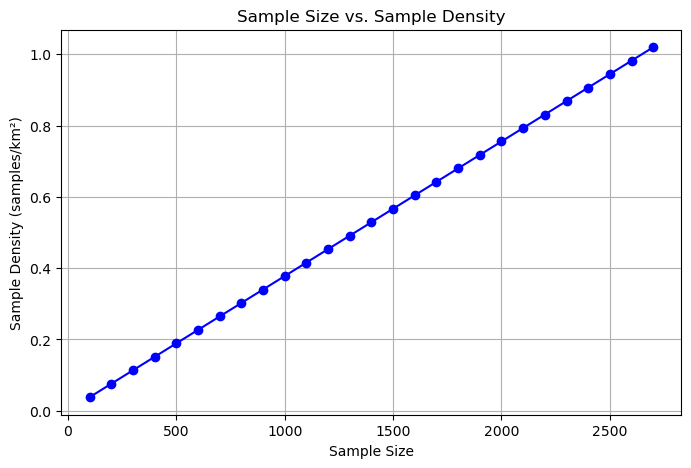

In [40]:
sample_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700]
sample_density = [size / area_km2 for size in sample_sizes]

plt.figure(figsize=(8,5))
plt.plot(sample_sizes, sample_density, marker='o', color='blue')
plt.xlabel('Sample Size')
plt.ylabel('Sample Density (samples/km²)')
plt.title('Sample Size vs. Sample Density')
plt.grid(True)
plt.show()

## Step 1: Bench mark model, predict LST using geographic X Y coordinates only

First model let's complete a round of KNN, and optimal K exploration. Mainly using the code from the lab

First model we will use X and Y coordinates only as predictors. X and Y bring the reletive geographic context.
According to Tobler's first law of geography, "everything is related to everything else, but near things are more related than distant things." If two measure points are close enough, their recorded temperature should be close enough as well.
To begin, we will standardize the X and Y coordinates

In [65]:
# Randomly select 1000 samples from the population
df_sample = df.sample(n=1000, random_state=seed)

# Standardize X and Y for the sampled data
scaler = StandardScaler()
df_sample[['sX', 'sY']] = scaler.fit_transform(df_sample[['x_coor', 'y_coor']])

# Output
print("Selected Predictor Features:", coord_features)
print("Standardized Feature Names:", std_cols)
print("Response Feature:", response)
print(f"Sampled Data Shape: {df_sample.shape}")
df_sample.tail()


Selected Predictor Features: ['x_coor', 'y_coor']
Standardized Feature Names: ['sX', 'sY']
Response Feature: Temperature
Sampled Data Shape: (1000, 16)


,x_coor,y_coor,B2_blue,B3_green,B4_red,B5_NIR,B6_SWIR1,B7_SWIR2,B8_pan,B9_cirrus,NDVI,EVI,NDWI,Temperature,sX,sY
3119,1475,1160,0.206921,0.174572,0.124966,0.658988,0.263176,0.095601,0.092272,0.001489,0.681190,1.558044,-0.581141,317.891205,0.963813,0.545581
1424,300,440,0.233947,0.201422,0.166967,0.560420,0.297572,0.157608,0.081336,0.001400,0.540912,1.217933,-0.471223,319.008900,-1.477378,-0.877380
2933,1653,628,0.312333,0.310286,0.295603,0.760656,0.476613,0.291215,0.129017,0.000956,0.440284,0.975547,-0.420537,325.397186,1.333628,-0.505829
3768,443,1579,0.217626,0.178842,0.150705,0.630032,0.327250,0.153240,0.083159,0.001289,0.613942,1.328411,-0.557800,320.755493,-1.180280,1.373666
3427,141,1449,0.207272,0.167377,0.116075,0.565275,0.225815,0.091506,0.070910,0.001312,0.659281,1.587991,-0.543094,314.818390,-1.807718,1.116742


Then we will do train-test split

In [66]:
# Train–test split using the standardized X and Y predictors
X_train, X_test, y_train, y_test = train_test_split(
    df_sample[['sX', 'sY']], df_sample[[response]], 
    test_size=0.25, random_state=73073
)

# Recombine predictors + response
df_train = pd.concat([X_train, y_train], axis=1)
df_test  = pd.concat([X_test, y_test], axis=1)

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), MachineLearning_knearest_neighbours.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/MachineLearningDemos_Book/blob/main/MachineLearning_knearest_neighbours.html). 
After we did the train-test split, let's visualize and compare them.
As you can see, this dataset is not competely random. The distribution of LST is not a normal distribution

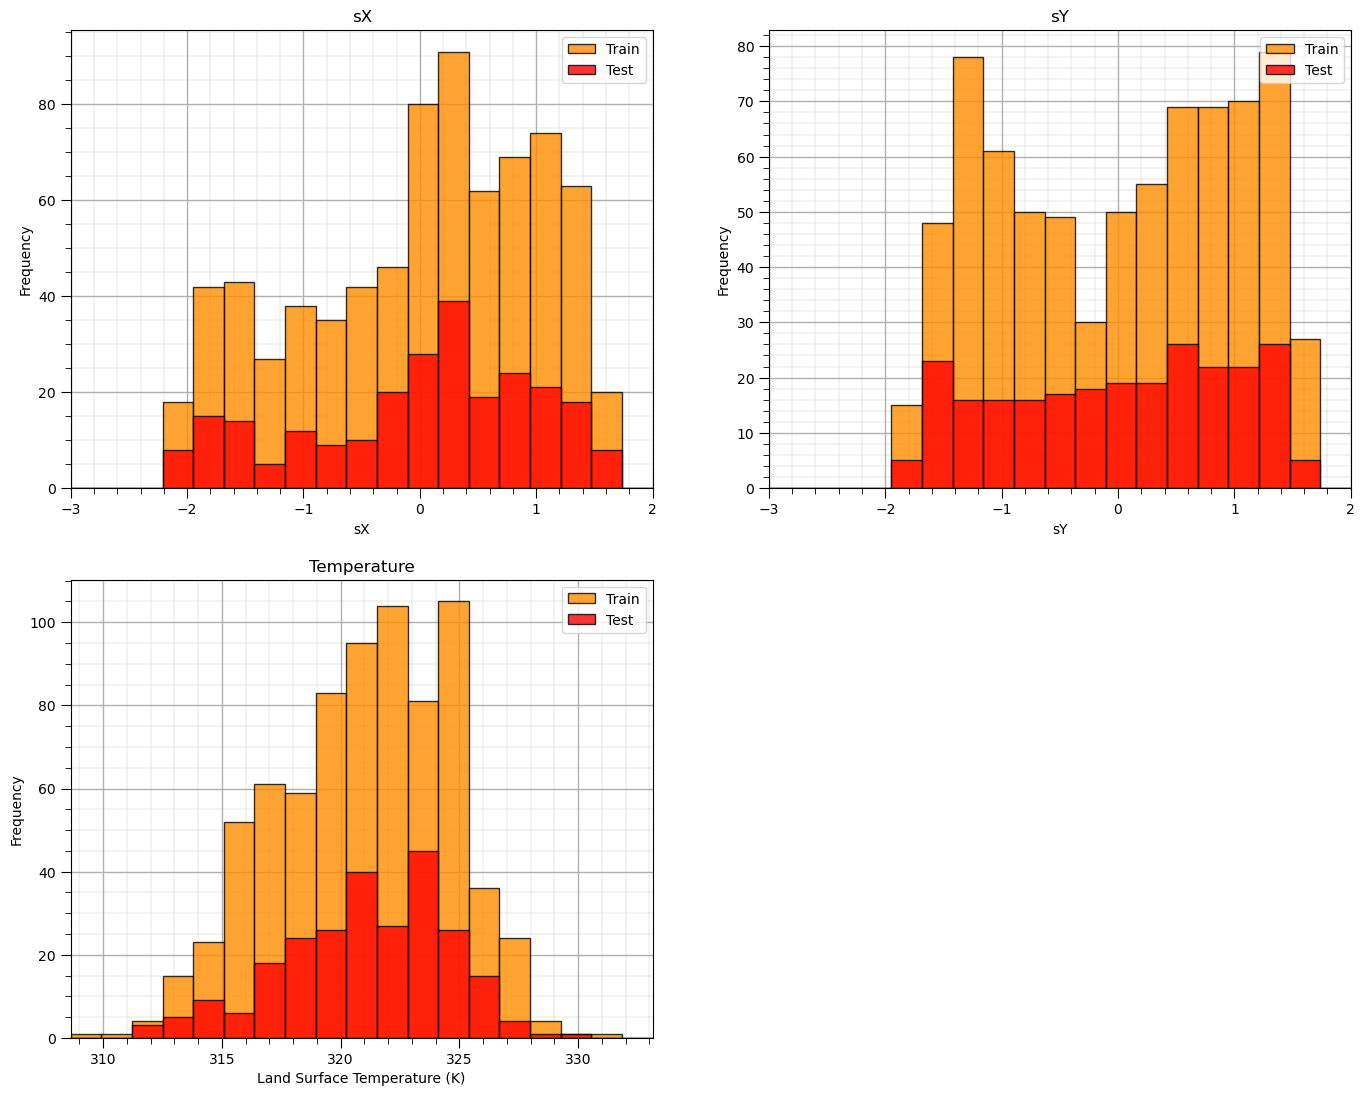

In [67]:
# Compute limits from standardized columns
sxmin, sxmax = df_sample[std_cols[0]].min(), df_sample[std_cols[0]].max()
symin_, symax_ = df_sample[std_cols[1]].min(), df_sample[std_cols[1]].max()

nbins = 20                                                    # number of histogram bins

plt.subplot(221)
plt.hist(X_train[std_cols[0]],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,2,nbins),label='Train')
plt.hist(X_test[std_cols[0]],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,2,nbins),label='Test')
plt.title(std_cols[0]); plt.xlim(-3,2); plt.xlabel(std_cols[0]); plt.ylabel('Frequency'); add_grid(); plt.legend(loc='upper right')

plt.subplot(222)
plt.hist(X_train[std_cols[1]],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(-3,2,nbins),label='Train')
plt.hist(X_test[std_cols[1]],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(-3,2,nbins),label='Test')
plt.title(std_cols[1]); plt.xlim(-3,2); plt.xlabel(std_cols[1]); plt.ylabel('Frequency'); add_grid(); plt.legend(loc='upper right')

plt.subplot(223)
plt.hist(y_train[resp],alpha = 0.8,color = 'darkorange',edgecolor = 'black',bins=np.linspace(ymin,ymax,nbins),label='Train')
plt.hist(y_test[resp],alpha = 0.8,color = 'red',edgecolor = 'black',bins=np.linspace(ymin,ymax,nbins),label='Test')
plt.legend(loc='upper right'); plt.title(resp[0]); plt.xlim(ymin,ymax) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
plt.xlabel(resplabel); plt.ylabel('Frequency'); add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2); plt.show()

Let's visualize the X and Y values of sample points and their temperature. You can read this as a map. 
For your reference, here is the real temperature map. You can see download Austin on East side of this map.

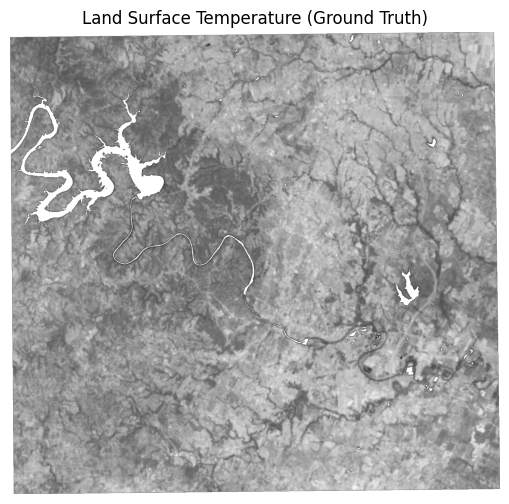

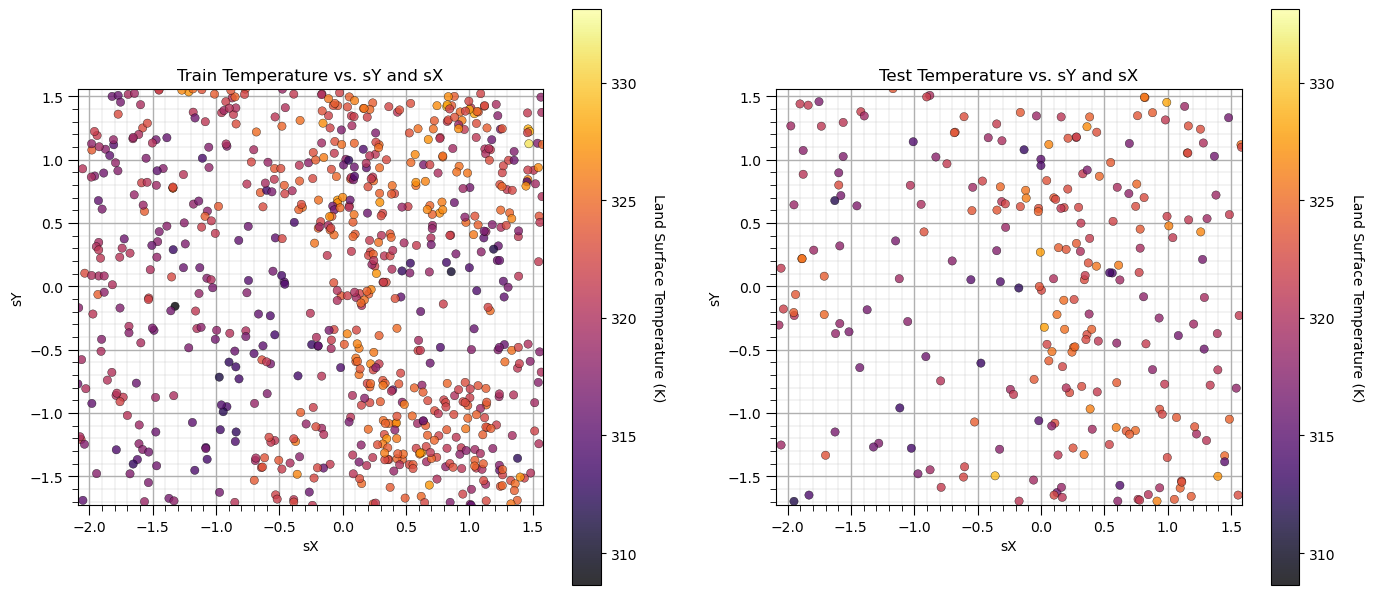

In [68]:


plt.subplot(121)                                              # train data plot
im = plt.scatter(X_train[std_cols[0]],X_train[std_cols[1]],s=None, c=y_train[resp[0]], marker=None, cmap=cmap, norm=None, vmin=ymin, 
                 vmax=ymax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Train ' + resp[0] + ' vs. ' + std_cols[1] + ' and ' + std_cols[0]); plt.xlabel(std_cols[0]); plt.ylabel(std_cols[1])
plt.xlim(sxmin, sxmax); plt.ylim(symin_, symax_)
plt.gca().set_aspect('equal', adjustable='box')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label(resplabel, rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
add_grid()

plt.subplot(122)                                               # test data plot
im = plt.scatter(X_test[std_cols[0]],X_test[std_cols[1]],s=None, c=y_test[resp[0]], marker=None, cmap=cmap, norm=None, vmin=ymin, 
                 vmax=ymax, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Test ' + resp[0] + ' vs. ' + std_cols[1] + ' and ' + std_cols[0]); plt.xlabel(std_cols[0]); plt.ylabel(std_cols[1])
plt.xlim(sxmin, sxmax); plt.ylim(symin_, symax_)
plt.gca().set_aspect('equal', adjustable='box')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label(resplabel, rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(comma_format))
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

Here we set up important KNN hyperparameters.
Since we have plenty of samples, I will let it consider n_neighbours. P = 2 for Euclidean distance. 
Weight is "distance". Which mean, the closer to the point, the more influence.

In [69]:
n_neighbours = 10; p = 2; weights = 'uniform'                # model hyperparameters
neigh = KNeighborsRegressor(weights = weights,n_neighbors=n_neighbours,p = p) # instantiate the prediction model

Here we visualize the results for the first X Y only KNN model for temperature prediction. The result is interesting. With just X Y values we can achieve a pretty reasonable prediction results.

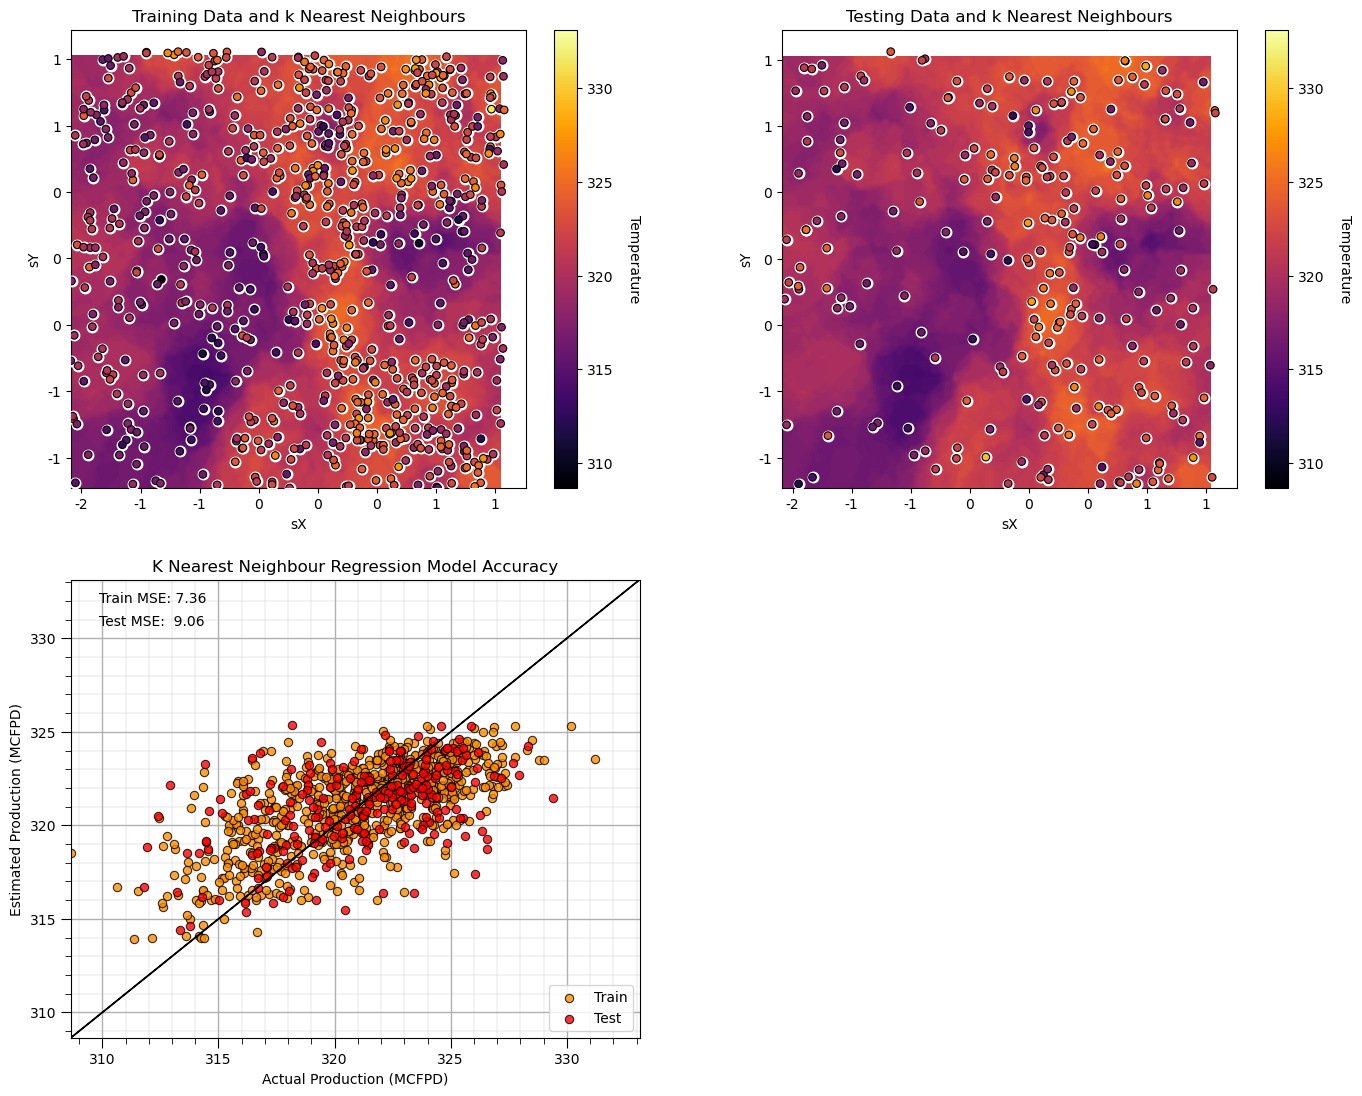

In [70]:
neigh_fit = neigh.fit(X_train,y_train)                        # train the model with the training data

plt.subplot(221)                                              # training data vs. the model predictions
Z = visualize_model(neigh_fit,X_train[std_cols[0]],sxmin,sxmax,X_train[std_cols[1]],symin_,symax_,y_train[resp[0]],ymin,ymax,
                    'Training Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplot(222)                                              # testing data vs. the model predictions
visualize_model(neigh_fit,X_test[std_cols[0]],sxmin,sxmax,X_test[std_cols[1]],symin_,symax_,y_test[resp[0]],ymin,ymax,
                'Testing Data and k Nearest Neighbours')
plt.annotate('Hyperparameters',[1.5,3.2],color='white'); plt.annotate('weights: ' + weights,[1.5,2.9],color='white')
plt.annotate('n neighbours: ' + str(n_neighbours),[1.5,2.6],color='white'); plt.annotate('distance norm: ' + str(p),[1.5,2.3],color='white')

plt.subplot(223)                                              # model accuracy check
check_model(neigh_fit,X_train[std_cols[0]],X_train[std_cols[1]],X_test[std_cols[0]],X_test[std_cols[1]],ymin,ymax,
            y_train[resp[0]],y_test[resp[0]],'K Nearest Neighbour Regression Model Accuracy')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.25, hspace=0.2); plt.show()

Here, we will do an experiment to get the most reasonable k value. 

In [71]:
k = 1                                                         # set initial, lowest k hyperparameter
dist_error = []; unif_error = []; k_mat = []                  # make lists to store the results
while k <= 100:                                               # loop over the k hyperparameter
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 2) # instantiate the model
    neigh_dist_fit = neigh_dist.fit(X_train,y_train)          # train the model with the training data
    y_pred = neigh_dist_fit.predict(X_test)                   # predict over the testing cases
    MSE = metrics.mean_squared_error(y_test,y_pred)           # calculate the MSE testing
    dist_error.append(MSE)                                    # add to the list of MSE
    
    neigh_unif = KNeighborsRegressor(weights = 'uniform', n_neighbors=k, p = 2)
    neigh_unif_fit = neigh_unif.fit(X_train,y_train)          # train the model with the training data
    y_pred = neigh_unif_fit.predict(X_test)                   # predict over the testing cases
    MSE = metrics.mean_squared_error(y_test,y_pred)           # calculate the MSE testing
    unif_error.append(MSE)                                    # add to the list of MSE
    
    k_mat.append(k)                                           # append k to an array for plotting
    k = k + 1

We plot the relationship between MSE and K. When K is around 10, the MSE reaches its min. 

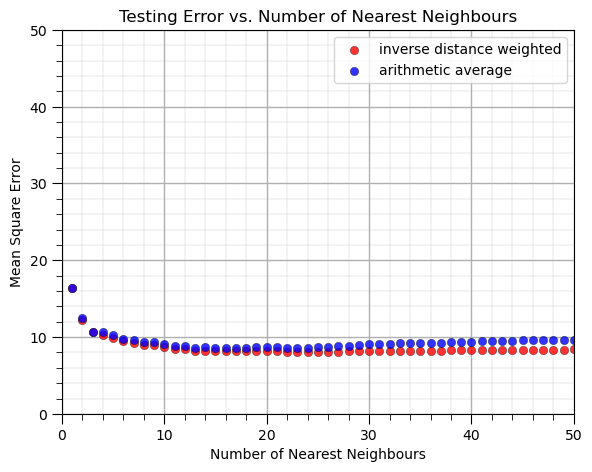

In [72]:
plt.subplot(111)
plt.scatter(k_mat,dist_error,s=None, c='red',label = 'inverse distance weighted', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.scatter(k_mat,unif_error,s=None, c='blue',label = 'arithmetic average', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.title('Testing Error vs. Number of Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error')
plt.legend(); add_grid()
plt.xlim(0,50); plt.ylim([0,50])
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=0.8,wspace=0.15,hspace=0.2); plt.show()

This is the integrated workflow. I will leave it here for now.

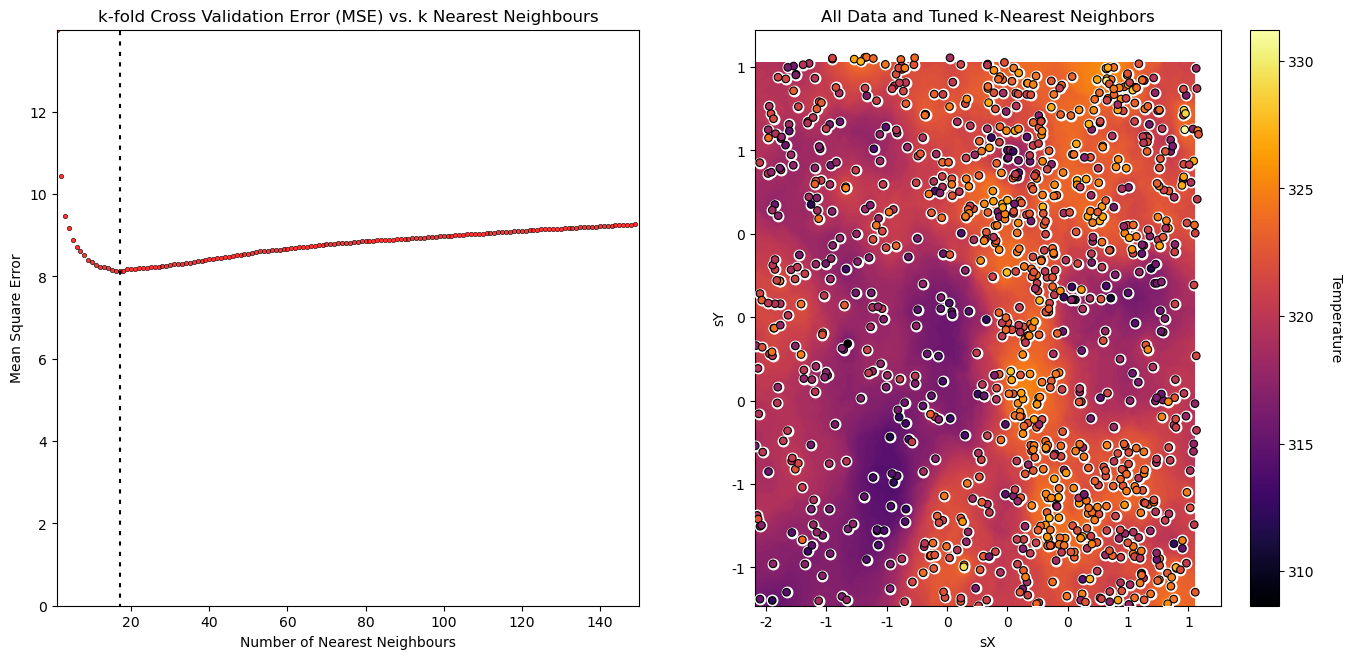

In [76]:
# In a combined workflow
# ------------------------------------------------------------
# Setup
# ------------------------------------------------------------
folds = 4
k_min = 1
k_max = 150

# Predictors: standardized X and Y
X_pipe = df_sample[['sX', 'sY']]

# Response
y_pipe = df_sample[response]   # remains 1D Series

# Machine learning pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knear', KNeighborsRegressor())
])

# Hyperparameter search space
params = {
    'scaler': [StandardScaler()],
    'knear__n_neighbors': np.arange(k_min, k_max, 1, dtype=int),
    'knear__metric': ['euclidean'],
    'knear__p': [2],              # p=2 → Euclidean
    'knear__weights': ['distance']
}

# Grid search cross-validation
grid_cv_tuned = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    scoring='neg_mean_squared_error',
    cv=KFold(n_splits=folds, shuffle=False),
    refit=True
)

# Fit the tuned model
grid_cv_tuned.fit(X_pipe, y_pipe)

# ------------------------------------------------------------
# Visualizations
# ------------------------------------------------------------
plt.subplot(121)
visualize_tuned_model(
    grid_cv_tuned.best_params_['knear__n_neighbors'],
    grid_cv_tuned.cv_results_['param_knear__n_neighbors'],
    abs(grid_cv_tuned.cv_results_['mean_test_score'])
)

plt.subplot(122)
visualize_model(
    grid_cv_tuned,
    df_sample['sX'], df_sample['sX'].min(), df_sample['sX'].max(),
    df_sample['sY'], df_sample['sY'].min(), df_sample['sY'].max(),
    df_sample[response], df_sample[response].min(), df_sample[response].max(),
    'All Data and Tuned k-Nearest Neighbors'
)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2,
                    wspace=0.2, hspace=0.2)
plt.show()


## Step 2: Determining the average Optimal K

I want to know the answer, if I am just taking randomly 1000 samples from the population (image the 3925 dataset as the population), what would be the optimal K on average? 

To answer this question, I will have to repeat multiple experiments, each time, I take 1000 samples from the population. And find the optimal K. until I have a better understanding of the Mean and Std of Optimal K under the 1000 sample circumstances. 

This is a bit like bootstrapping, but without replacment. 

In [78]:
# --- Experiment Setup ---
n_iterations = 1000
sample_size = 1000
k_range = np.arange(1, 51)  # Test k from 1 to 50
predictor_features = ['x_coor', 'y_coor']
optimal_ks = []

Here we begin, we just need one loop

Running iteration 1/1000...
Running iteration 2/1000...
Running iteration 3/1000...
Running iteration 4/1000...
Running iteration 5/1000...
Running iteration 6/1000...
Running iteration 7/1000...
Running iteration 8/1000...
Running iteration 9/1000...
Running iteration 10/1000...
Running iteration 11/1000...
Running iteration 12/1000...
Running iteration 13/1000...
Running iteration 14/1000...
Running iteration 15/1000...
Running iteration 16/1000...
Running iteration 17/1000...
Running iteration 18/1000...
Running iteration 19/1000...
Running iteration 20/1000...
Running iteration 21/1000...
Running iteration 22/1000...
Running iteration 23/1000...
Running iteration 24/1000...
Running iteration 25/1000...
Running iteration 26/1000...
Running iteration 27/1000...
Running iteration 28/1000...
Running iteration 29/1000...
Running iteration 30/1000...
Running iteration 31/1000...
Running iteration 32/1000...
Running iteration 33/1000...
Running iteration 34/1000...
Running iteration 35/10

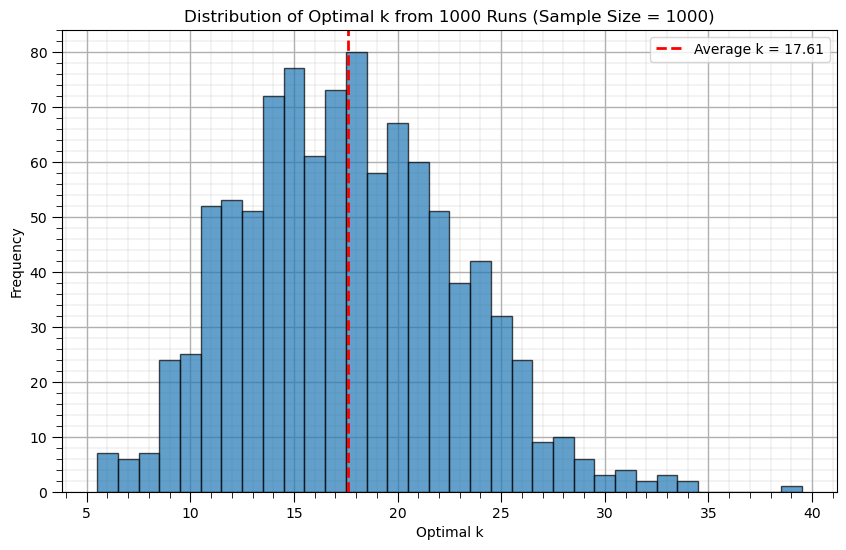

In [79]:
# --- Main Loop for Experiment ---
for i in range(n_iterations):
    print(f"Running iteration {i + 1}/{n_iterations}...")
    
    # 1. Randomly sample 1000 points from the 3925 dataset without replacement
    df_sample = df.sample(n=sample_size, replace=False)
    X_sample = df_sample[predictor_features]
    y_sample = df_sample[response]

    # 2. Set up a pipeline with scaling and KNN
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knear', KNeighborsRegressor(weights='distance'))
    ])
    
    # 3. Use GridSearchCV to find the best k for this sample
    params = {'knear__n_neighbors': k_range}
    grid_search = GridSearchCV(
        pipe,
        param_grid=params,
        scoring='neg_mean_squared_error',
        cv=5  # 5-fold cross-validation
    )
    
    grid_search.fit(X_sample, y_sample)
    
    # 4. Store the best k found
    best_k = grid_search.best_params_['knear__n_neighbors']
    optimal_ks.append(best_k)

print("\nExperiment complete.")

Here we show the results

In [ ]:

# --- Analyze and Plot Results ---
avg_optimal_k = np.mean(optimal_ks)
std_optimal_k = np.std(optimal_ks)

print(f"\nAverage Optimal k: {avg_optimal_k:.2f}")
print(f"Standard Deviation of Optimal k: {std_optimal_k:.2f}")

# Plot the distribution of optimal k values
plt.figure(figsize=(10, 6))
plt.hist(optimal_ks, bins=np.arange(min(optimal_ks)-0.5, max(optimal_ks)+1.5, 1), edgecolor='black', alpha=0.7)
plt.axvline(avg_optimal_k, color='red', linestyle='dashed', linewidth=2, label=f'Average k = {avg_optimal_k:.2f}')
plt.title(f'Distribution of Optimal k from {n_iterations} Runs (Sample Size = {sample_size})')
plt.xlabel('Optimal k')
plt.ylabel('Frequency')
plt.legend()
add_grid()
plt.show()

we also notice that given a sample size (sample density), the Optimal K is also not very stable, with STD to be around 5. In means that in a few time

## Step 2: Searching for the optimal K, when sample size changes

Given that, I want to see how the distribution of Optimal K change, as the sample size changes. I will explore the distribution of Optimal K, when we have 100, 200, 300, and all the way to 2700 samples within our study scope. 

When there are 2,700 samples, the data density is roughly 1 point per 1 km2

This experiement will take a very long time to run. If you do not want to wait. You can load the results and visualize them. I run the simulation for 1000 iterations for each sample size. If you want to test this code, you can also set the interation to be 10, which will be siginficantly faster. But given the results in step 2, we must need to have higher number of iteration to generate stable results. 

In [127]:
# --- Experiment Setup ---
sample_size = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700]
n_iterations = 1000
k_range = np.arange(1, 80)  # Test k from 1 to 50
predictor_features = ['x_coor', 'y_coor']

Here is the core part of this exprienment. A three layer looping logic. First layer is about sample sizes, starting from 100, incremental for 100 all the way to 2700 samples, second layer in number of iterations, for this test, noticing that STD is actually pretty high, I choose to have a higher number of iteration. For later iteration is built in the Optimal K searching. I test K values from 1 to 50 and look for the optimal K each time. 

In [128]:
# Lists to store the summary statistics
avg_k_per_size = []
std_k_per_size = []
avg_mse_per_size = []

# --- Main Experiment 
# Outer loop: iterates over each sample size
for size in sample_size:
    print(datetime.now())
    print(f"Processing sample size: {size}...")
    optimal_ks_for_size = []  # Store optimal k's for the current size
    mses_for_size = []        # Store MSEs for the current size
    
    # Medium loop: repeats the CV process to find optimal k multiple times
    for i in range(n_iterations):

        # 1. Randomly sample data without replacement
        df_sample = df.sample(n=size, replace=False)
        X_sample = df_sample[predictor_features]
        y_sample = df_sample[response]

        # 2. Set up pipeline
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knear', KNeighborsRegressor(weights='distance'))
        ])
        
        # Inner loop: hyperparameter tuning (searching for optimal K) with GridSearchCV
        # 3. Use GridSearchCV to find the best k
        params = {'knear__n_neighbors': k_range}
        grid_search = GridSearchCV(
            pipe,
            param_grid=params,
            scoring='neg_mean_squared_error',
            cv=5  # 5-fold cross-validation
        )
        
        grid_search.fit(X_sample, y_sample)
        
        # 4. Store the best k and the corresponding MSE
        optimal_ks_for_size.append(grid_search.best_params_['knear__n_neighbors'])
        mses_for_size.append(-grid_search.best_score_) # best_score_ is negative MSE
    
    # Calculate and store the mean and std of optimal k
    avg_k = np.mean(optimal_ks_for_size)
    std_k = np.std(optimal_ks_for_size)
    avg_k_per_size.append(avg_k)
    std_k_per_size.append(std_k)
    
    # Calculate and store the mean MSE
    avg_mse = np.mean(mses_for_size)
    avg_mse_per_size.append(avg_mse)
    
    print(f"  -> Avg k: {avg_k:.2f} (Std: {std_k:.2f}), Avg MSE: {avg_mse:.2f}")

print("\nExperiment complete.")



2025-11-27 23:23:01.820339
Processing sample size: 100...
  -> Avg k: 19.93 (Std: 14.76), Avg MSE: 10.62
2025-11-27 23:32:11.076260
Processing sample size: 200...
  -> Avg k: 19.12 (Std: 9.65), Avg MSE: 9.90
2025-11-27 23:39:51.705210
Processing sample size: 300...
  -> Avg k: 18.40 (Std: 8.97), Avg MSE: 9.48
2025-11-27 23:47:49.933671
Processing sample size: 400...
  -> Avg k: 17.83 (Std: 7.76), Avg MSE: 9.22
2025-11-27 23:56:17.183145
Processing sample size: 500...
  -> Avg k: 17.42 (Std: 6.10), Avg MSE: 8.98
2025-11-28 00:05:12.683560
Processing sample size: 600...
  -> Avg k: 17.69 (Std: 5.33), Avg MSE: 8.76
2025-11-28 00:14:36.700209
Processing sample size: 700...
  -> Avg k: 17.61 (Std: 4.81), Avg MSE: 8.60
2025-11-28 00:24:12.902762
Processing sample size: 800...
  -> Avg k: 17.40 (Std: 4.63), Avg MSE: 8.51
2025-11-28 00:34:17.546780
Processing sample size: 900...
  -> Avg k: 17.65 (Std: 4.90), Avg MSE: 8.38
2025-11-28 00:44:49.007570
Processing sample size: 1000...
  -> Avg k: 

In [129]:

# --- Save and Display Results ---
# Create a DataFrame from the results
results_df = pd.DataFrame({
    'sample_size': sample_size,
    'avg_optimal_k': avg_k_per_size,
    'std_optimal_k': std_k_per_size,
    'avg_mse': avg_mse_per_size
})

# Save the DataFrame to a CSV file
results_df.to_csv('knn_experiment_results_x_y.csv', index=False)

# Display the results DataFrame
print("\n--- Summary of Results ---")
display(results_df)


--- Summary of Results ---


,sample_size,avg_optimal_k,std_optimal_k,avg_mse
0,100,19.935,14.764037,10.621172
1,200,19.123,9.652351,9.901432
2,300,18.404,8.970105,9.482935
3,400,17.833,7.763834,9.219194
4,500,17.424,6.102313,8.983623
5,600,17.691,5.333247,8.755911
6,700,17.608,4.811895,8.599114
7,800,17.401,4.629708,8.509231
8,900,17.654,4.901865,8.381205
9,1000,17.179,4.821510,8.245411


Without much a double, when you have more samples, the MSE is lower and the model is more accurate

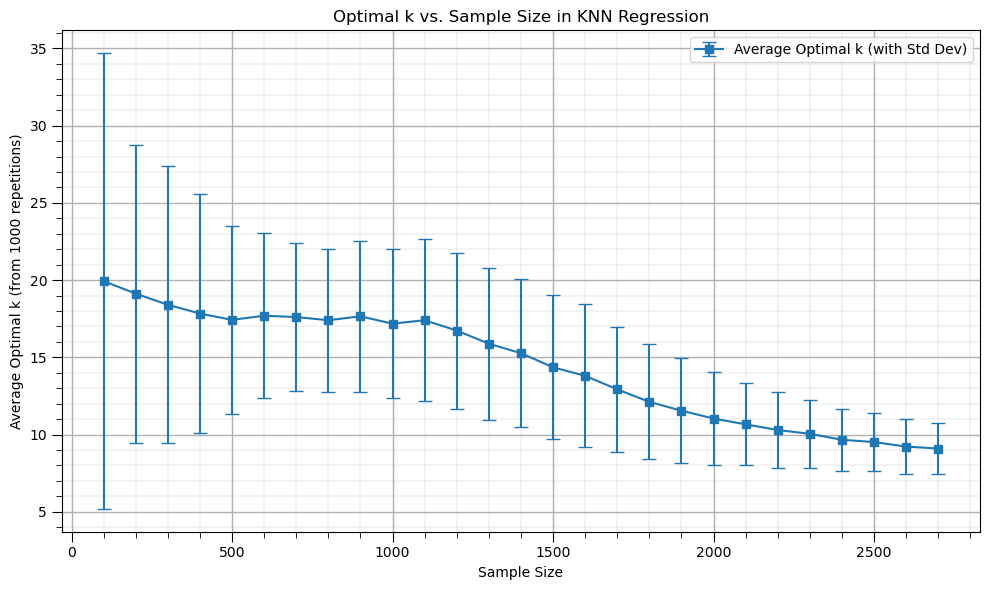

In [130]:
# --- Plot 1: Optimal k vs. Sample Size ---
plt.figure(figsize=(10, 6))
plt.errorbar(sample_size, avg_k_per_size, yerr=std_k_per_size, fmt='-o', capsize=5,
             marker='s', markersize=6, label='Average Optimal k (with Std Dev)')
plt.title('Optimal k vs. Sample Size in KNN Regression')
plt.xlabel('Sample Size')
plt.ylabel(f'Average Optimal k (from {n_iterations} repetitions)')
plt.legend()
add_grid()
plt.tight_layout()
plt.show()

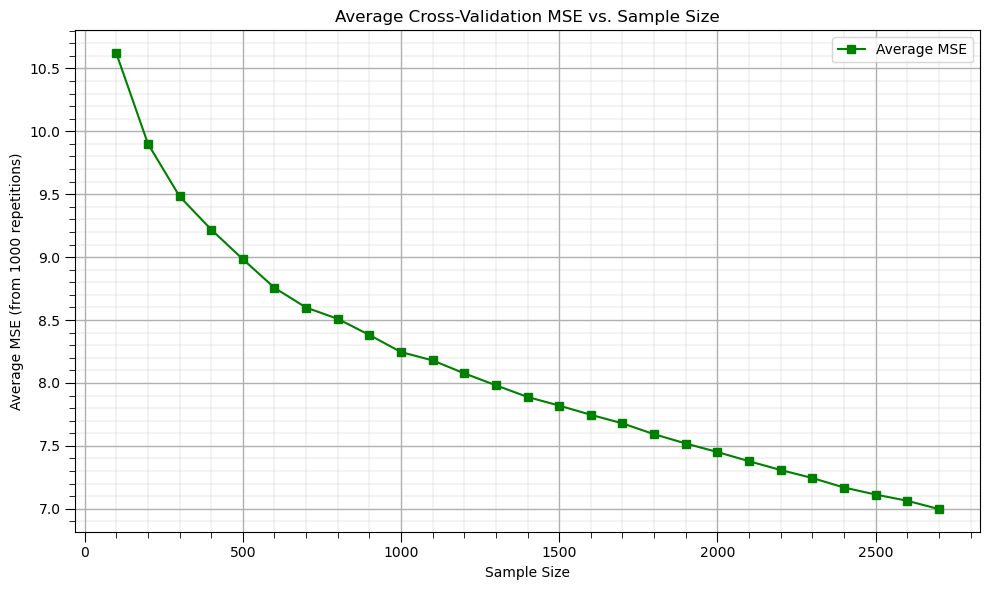

In [131]:
# --- Plot 2: MSE vs. Sample Size ---
plt.figure(figsize=(10, 6))
plt.plot(sample_size, avg_mse_per_size, '-o', color='green', marker='s', markersize=6, label='Average MSE')
plt.title('Average Cross-Validation MSE vs. Sample Size')
plt.xlabel('Sample Size')
plt.ylabel(f'Average MSE (from {n_iterations} repetitions)')
plt.legend()
add_grid()
plt.tight_layout()
plt.show()

In [ ]:
# sample_sizes = [100, 200, 300, 400, 500, 600, 700, 800]
# n_reps = 50
# k_range = np.arange(1, 50)

# predictor_features = ["x_coor", "y_coor"]
# X_full = df[predictor_features]
# y_full = df[response]

# # 1) Fixed test set (optional but recommended)
# from sklearn.model_selection import train_test_split
# X_train_full, X_test, y_train_full, y_test = train_test_split(
#     X_full, y_full, test_size=0.2, random_state=42
# )

# results_k = {}
# results_rmse = {}

# for size in sample_sizes:
#     print(f"Processing sample size: {size}...")
#     optimal_ks = []
#     rmse_test_list = []
    
#     for i in range(n_reps):
#         # 2) Subsample without replacement from training pool
#         idx = np.random.choice(len(X_train_full), size=size, replace=False)
#         X_sample = X_train_full.iloc[idx]
#         y_sample = y_train_full.iloc[idx]

#         # 3) Pipeline + CV for k
#         pipe = Pipeline([
#             ('scaler', StandardScaler()),
#             ('knear', KNeighborsRegressor(weights='uniform'))
#         ])
#         params = {'knear__n_neighbors': k_range}

#         grid_search = GridSearchCV(
#             pipe,
#             param_grid=params,
#             scoring='neg_mean_squared_error',
#             cv=5
#         )
#         grid_search.fit(X_sample, y_sample)
#         best_k = grid_search.best_params_['knear__n_neighbors']
#         optimal_ks.append(best_k)

#         # 4) Evaluate best k on fixed test set
#         best_model = grid_search.best_estimator_
#         y_pred_test = best_model.predict(X_test)
#         rmse_test = np.sqrt(np.mean((y_pred_test - y_test) ** 2))
#         rmse_test_list.append(rmse_test)

#     results_k[size] = optimal_ks
#     results_rmse[size] = rmse_test_list
#     print(f"  Avg optimal k: {np.mean(optimal_ks):.2f}, "
#           f"Avg test RMSE: {np.mean(rmse_test_list):.4f}")


Processing sample size: 100...
  Avg optimal k: 10.48, Avg test RMSE: 3.4041
Processing sample size: 200...
  Avg optimal k: 12.68, Avg test RMSE: 3.2839
Processing sample size: 300...
  Avg optimal k: 12.52, Avg test RMSE: 3.2114
Processing sample size: 400...
  Avg optimal k: 13.78, Avg test RMSE: 3.1627
Processing sample size: 500...
  Avg optimal k: 12.10, Avg test RMSE: 3.1226
Processing sample size: 600...
  Avg optimal k: 13.22, Avg test RMSE: 3.1037
Processing sample size: 700...
  Avg optimal k: 12.26, Avg test RMSE: 3.0848
Processing sample size: 800...
  Avg optimal k: 11.92, Avg test RMSE: 3.0657


## Step 4: Optimal K Searching, with models including x_coor y_coor and NDVI (Normalized Vegetation Index)

In this last experiment, I want to test if the same effect can still be observed if I add one more features for prediction. Besides x_coor and y_coor, I added the NDVI index, an index showing the bundance of vegetation. This index has been mentioned by many literature to have high corelation with temperature. In short, the higher the amount of vegetation, the lower the temperature. Based on our data exploration. I also found that NDVI has an coorelation of nearly -0.71 with temperature, making it one of the most suitable features for predicting temperation. Now if I combine NDVI and x_coor, y_coor. I want to see if our observations still stand. 

In [132]:
# --- Experiment Setup ---
n_iterations = 1000 
sample_size = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700]
k_range = np.arange(1, 80)  # Test k from 1 to 50
predictor_features = ['x_coor', 'y_coor', "NDVI"]

In [133]:
# Lists to store the summary statistics
avg_k_per_size_ndvi = []
std_k_per_size_ndvi = []
avg_mse_per_size_ndvi = []

# --- Main Experiment 
# Outer loop: iterates over each sample size
for size in sample_size:
    print(datetime.now())
    print(f"Processing sample size: {size}...")
    optimal_ks_for_size = []  # Store optimal k's for the current size
    mses_for_size = []        # Store MSEs for the current size
    
    # Medium loop: repeats the CV process to find optimal k multiple times
    for i in range(n_iterations):

        # 1. Randomly sample data without replacement
        df_sample = df.sample(n=size, replace=False)
        X_sample = df_sample[predictor_features]
        y_sample = df_sample[response]

        # 2. Set up pipeline
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knear', KNeighborsRegressor(weights='distance'))
        ])
        
        # Inner loop: hyperparameter tuning (searching for optimal K) with GridSearchCV
        # 3. Use GridSearchCV to find the best k
        params = {'knear__n_neighbors': k_range}
        grid_search = GridSearchCV(
            pipe,
            param_grid=params,
            scoring='neg_mean_squared_error',
            cv=5  # 5-fold cross-validation
        )
        
        grid_search.fit(X_sample, y_sample)
        
        # 4. Store the best k and the corresponding MSE
        optimal_ks_for_size.append(grid_search.best_params_['knear__n_neighbors'])
        mses_for_size.append(-grid_search.best_score_) # best_score_ is negative MSE
    
    # Calculate and store the mean and std of optimal k
    avg_k = np.mean(optimal_ks_for_size)
    std_k = np.std(optimal_ks_for_size)
    avg_k_per_size_ndvi.append(avg_k)
    std_k_per_size_ndvi.append(std_k)
    
    # Calculate and store the mean MSE
    avg_mse = np.mean(mses_for_size)
    avg_mse_per_size_ndvi.append(avg_mse)
    
    print(f"  -> Avg k: {avg_k:.2f} (Std: {std_k:.2f}), Avg MSE: {avg_mse:.2f}")

print("\nExperiment complete.")



2025-11-28 05:11:36.984411
Processing sample size: 100...
  -> Avg k: 9.17 (Std: 4.18), Avg MSE: 6.34
2025-11-28 05:21:04.577053
Processing sample size: 200...
  -> Avg k: 11.79 (Std: 4.45), Avg MSE: 5.79
2025-11-28 05:29:03.499969
Processing sample size: 300...
  -> Avg k: 13.10 (Std: 4.55), Avg MSE: 5.55
2025-11-28 05:37:45.580990
Processing sample size: 400...
  -> Avg k: 14.52 (Std: 4.66), Avg MSE: 5.46
2025-11-28 05:47:00.974288
Processing sample size: 500...
  -> Avg k: 15.30 (Std: 4.74), Avg MSE: 5.33
2025-11-28 05:56:50.459324
Processing sample size: 600...
  -> Avg k: 16.42 (Std: 4.85), Avg MSE: 5.23
2025-11-28 06:07:44.074580
Processing sample size: 700...
  -> Avg k: 17.40 (Std: 4.77), Avg MSE: 5.17
2025-11-28 06:19:18.572362
Processing sample size: 800...
  -> Avg k: 17.99 (Std: 4.95), Avg MSE: 5.12
2025-11-28 06:31:25.460608
Processing sample size: 900...
  -> Avg k: 18.33 (Std: 5.02), Avg MSE: 5.06
2025-11-28 06:43:19.084215
Processing sample size: 1000...
  -> Avg k: 18.

In [134]:
# --- Save and Display Results ---
# Create a DataFrame from the results
results_df_ndvi = pd.DataFrame({
    'sample_size': sample_size,
    'avg_optimal_k': avg_k_per_size_ndvi,
    'std_optimal_k': std_k_per_size_ndvi,
    'avg_mse': avg_mse_per_size_ndvi
})

# Save the DataFrame to a CSV file
results_df_ndvi.to_csv('knn_experiment_results_x_y_ndvi.csv', index=False)

# Display the results DataFrame
print("\n--- Summary of Results ---")
display(results_df_ndvi)


--- Summary of Results ---


,sample_size,avg_optimal_k,std_optimal_k,avg_mse
0,100,9.169,4.183114,6.338245
1,200,11.792,4.446654,5.785653
2,300,13.095,4.547304,5.554618
3,400,14.516,4.655507,5.458682
4,500,15.296,4.742403,5.328487
5,600,16.424,4.851415,5.229828
6,700,17.403,4.773949,5.171169
7,800,17.989,4.945390,5.117411
8,900,18.330,5.020468,5.062992
9,1000,18.805,5.206628,5.027923


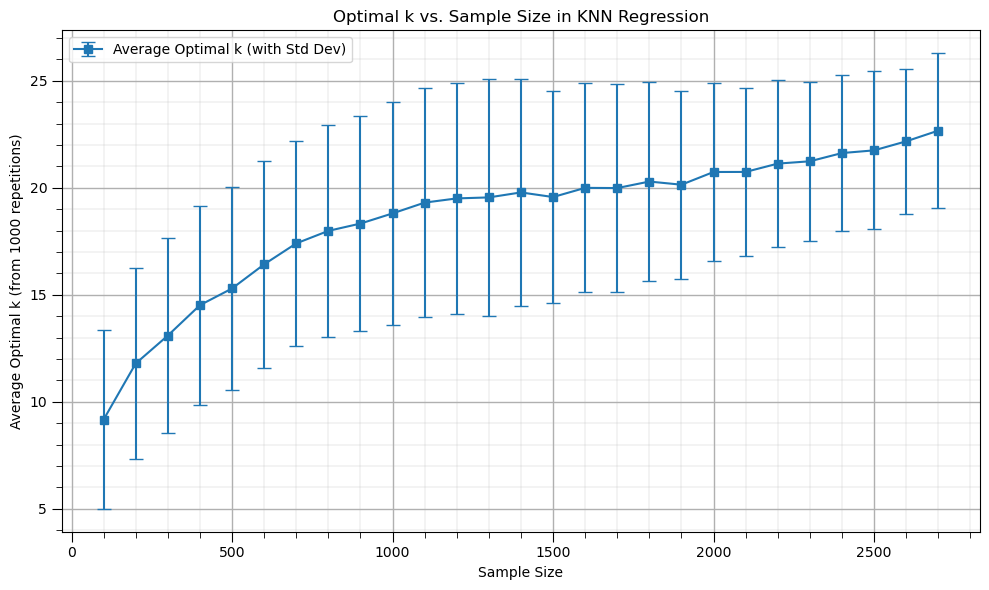

In [135]:
# --- Plot 1: Optimal k vs. Sample Size ---
plt.figure(figsize=(10, 6))
plt.errorbar(sample_size, avg_k_per_size_ndvi, yerr=std_k_per_size_ndvi, fmt='-o', capsize=5,
             marker='s', markersize=6, label='Average Optimal k (with Std Dev)')
plt.title('Optimal k vs. Sample Size in KNN Regression')
plt.xlabel('Sample Size')
plt.ylabel(f'Average Optimal k (from {n_iterations} repetitions)')
plt.legend()
add_grid()
plt.tight_layout()
plt.show()

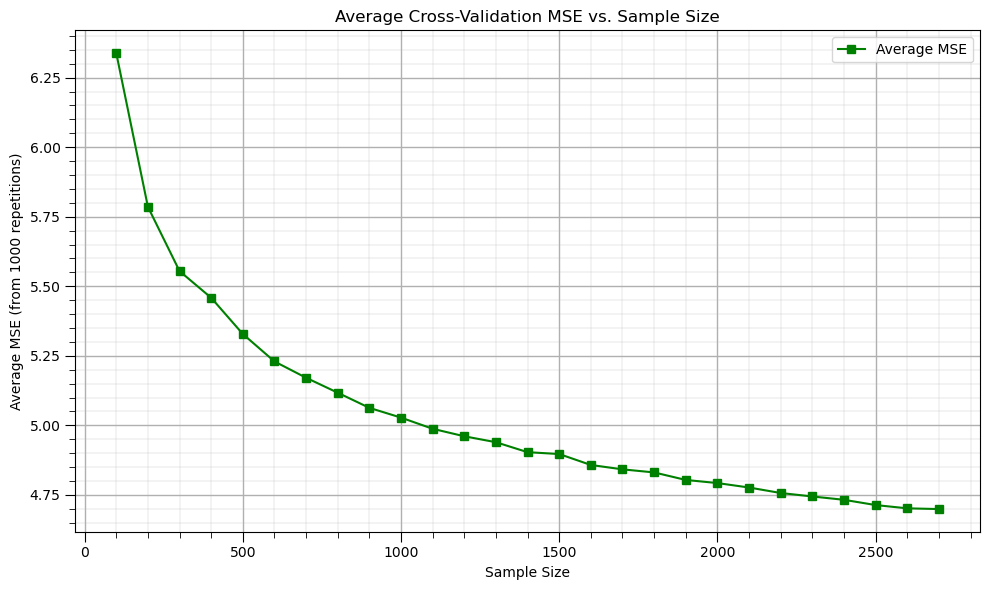

In [136]:
# --- Plot 2: MSE vs. Sample Size ---
plt.figure(figsize=(10, 6))
plt.plot(sample_size, avg_mse_per_size_ndvi, '-o', color='green', marker='s', markersize=6, label='Average MSE')
plt.title('Average Cross-Validation MSE vs. Sample Size')
plt.xlabel('Sample Size')
plt.ylabel(f'Average MSE (from {n_iterations} repetitions)')
plt.legend()
add_grid()
plt.tight_layout()
plt.show()

Processing sample size: 100...
Done. Average optimal k: 10.94

Processing sample size: 200...
Done. Average optimal k: 8.44

Processing sample size: 300...
Done. Average optimal k: 6.61

Processing sample size: 400...
Done. Average optimal k: 5.07

Processing sample size: 500...
Done. Average optimal k: 3.63

Processing sample size: 600...
Done. Average optimal k: 2.29

Processing sample size: 700...
Done. Average optimal k: 1.64

Processing sample size: 800...
Done. Average optimal k: 1.24



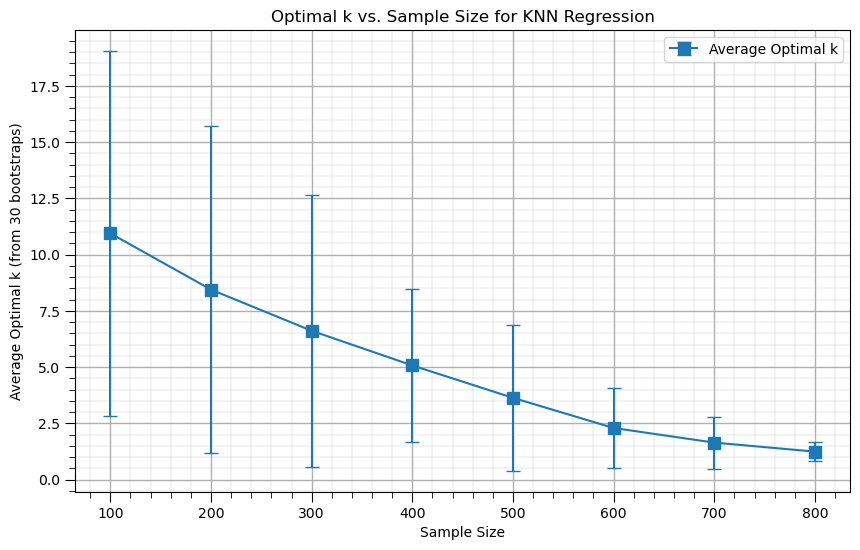

In [19]:
# ...existing code...
# This is a new cell to implement the bootstrapping experiment

# --- Experiment Setup ---
sample_sizes = [100, 200, 300, 400, 500, 600, 700, 800]
n_bootstraps = 100  # Number of bootstrap iterations for each sample size
k_range = np.arange(1, 50) # Range of k values to test

# Use all spectral and index features as predictors
predictor_features = ["X_coor", "Y_coor"]
X_full = df[predictor_features]
y_full = df[response]

results = {}

# --- Main Loop ---
for size in sample_sizes:
    print(f"Processing sample size: {size}...")
    optimal_ks = []
    
    for i in range(n_bootstraps):
        # Create a bootstrap sample (sampling with replacement)
        bootstrap_indices = np.random.choice(len(df), size=size, replace=True)
        X_sample = X_full.iloc[bootstrap_indices]
        y_sample = y_full.iloc[bootstrap_indices]

        # Setup the pipeline and grid search for this sample
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knear', KNeighborsRegressor(weights='uniform'))
        ])
        
        params = {'knear__n_neighbors': k_range}
        
        grid_search = GridSearchCV(
            pipe,
            param_grid=params,
            scoring='neg_mean_squared_error',
            cv=5 # 5-fold cross-validation
        )
        
        # Find the best k for this bootstrap sample
        grid_search.fit(X_sample, y_sample)
        optimal_ks.append(grid_search.best_params_['knear__n_neighbors'])

    # Store the distribution of optimal k's for this sample size
    results[size] = optimal_ks
    print(f"Done. Average optimal k: {np.mean(optimal_ks):.2f}\n")

# --- Analyze and Plot Results ---
avg_k = [np.mean(results[s]) for s in sample_sizes]
std_k = [np.std(results[s]) for s in sample_sizes]

plt.figure(figsize=(10, 6))
plt.errorbar(sample_sizes, avg_k, yerr=std_k, fmt='-o', capsize=5,
             marker='s', markersize=8, label='Average Optimal k')
plt.title('Optimal k vs. Sample Size for KNN Regression')
plt.xlabel('Sample Size')
plt.ylabel('Average Optimal k (from 30 bootstraps)')
plt.xticks(sample_sizes)
plt.legend()
add_grid()
plt.show()

In [20]:
sample_sizes = [100, 200, 300, 400, 500, 600, 700, 800]
n_reps = 50
k_range = np.arange(1, 50)

predictor_features = ["X_coor", "Y_coor"]
X_full = df[predictor_features]
y_full = df[response]

# 1) Fixed test set (optional but recommended)
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

results_k = {}
results_rmse = {}

for size in sample_sizes:
    print(f"Processing sample size: {size}...")
    optimal_ks = []
    rmse_test_list = []
    
    for i in range(n_reps):
        # 2) Subsample without replacement from training pool
        idx = np.random.choice(len(X_train_full), size=size, replace=False)
        X_sample = X_train_full.iloc[idx]
        y_sample = y_train_full.iloc[idx]

        # 3) Pipeline + CV for k
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knear', KNeighborsRegressor(weights='uniform'))
        ])
        params = {'knear__n_neighbors': k_range}

        grid_search = GridSearchCV(
            pipe,
            param_grid=params,
            scoring='neg_mean_squared_error',
            cv=5
        )
        grid_search.fit(X_sample, y_sample)
        best_k = grid_search.best_params_['knear__n_neighbors']
        optimal_ks.append(best_k)

        # 4) Evaluate best k on fixed test set
        best_model = grid_search.best_estimator_
        y_pred_test = best_model.predict(X_test)
        rmse_test = np.sqrt(np.mean((y_pred_test - y_test) ** 2))
        rmse_test_list.append(rmse_test)

    results_k[size] = optimal_ks
    results_rmse[size] = rmse_test_list
    print(f"  Avg optimal k: {np.mean(optimal_ks):.2f}, "
          f"Avg test RMSE: {np.mean(rmse_test_list):.4f}")


Processing sample size: 100...
  Avg optimal k: 11.50, Avg test RMSE: 4.8430
Processing sample size: 200...
  Avg optimal k: 12.18, Avg test RMSE: 4.7100
Processing sample size: 300...
  Avg optimal k: 10.04, Avg test RMSE: 4.5624
Processing sample size: 400...
  Avg optimal k: 9.00, Avg test RMSE: 4.4709
Processing sample size: 500...
  Avg optimal k: 7.92, Avg test RMSE: 4.3475
Processing sample size: 600...
  Avg optimal k: 8.84, Avg test RMSE: 4.3043
Processing sample size: 700...
  Avg optimal k: 9.90, Avg test RMSE: 4.2844
Processing sample size: 800...
  Avg optimal k: 10.70, Avg test RMSE: 4.2411


### Name of My Workflow

A short summary of your workflow. This is a suggestion. The main thing is to be clear and concise. Easy to follow!

1. If helpful, you could include

2. enumeration

### 1. Name Your First Workflow Step

This is a short summary of this step.

Short Markdown block, code, concise and essential output summaries, repeat  

### 2. Name Your Second Workflow Step

Repeat as needed

### Results

Final summary of results, include table (DataFrame) and / plots, answer the problem and demonstrate the work stated in the executive summary.

### Parting Comments / Promote You

Consider adding any information to promote your capabilities, interest in internships, full-time positions. 

* This workflow will be shared / posted online and will promote you. 

* It is optional to retain my information below yours. This may also provide some ideas.


#### About the Supervising Professor

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)